<a href="https://colab.research.google.com/github/golnazads/ColabNotebooks/blob/main/interpreting_astrobert_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting AstroBERT NER with LIME


## Installation

ELI5 (Explain Like I am 5-year-old) is a Python package which provides visualization capabilities for machine learning interpretation tools, including LIME.


In [ ]:
!pip install transformers
!pip install eli5

## deprecated 'itemfreq' function, called from eli5 library, monkey patch

source: https://stackoverflow.com/questions/73556675/issue-with-importing-textexplainer-from-eli5-lime-package-relating-to-deprecated

In [ ]:
import scipy
import numpy as np
def monkeypath_itemfreq(sampler_indices):
   return zip(*np.unique(sampler_indices, return_counts=True))

scipy.stats.itemfreq=monkeypath_itemfreq

## Import AstroBERT NER model

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# load astroBERT for NER-DEAL
remote_model_path = 'adsabs/astroBERT'
revision = 'NER-DEAL'

model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path=remote_model_path, revision=revision)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=remote_model_path, add_special_tokens=True, do_lower_case=False)

Display all possible entity tags that this model classifies each token into:

In [ ]:
id2lable = model.config.id2label
id2lable

{0: 'B-Archive',
 1: 'B-CelestialObject',
 2: 'B-CelestialObjectRegion',
 3: 'B-CelestialRegion',
 4: 'B-Citation',
 5: 'B-Collaboration',
 6: 'B-ComputingFacility',
 7: 'B-Database',
 8: 'B-Dataset',
 9: 'B-EntityOfFutureInterest',
 10: 'B-Event',
 11: 'B-Fellowship',
 12: 'B-Formula',
 13: 'B-Grant',
 14: 'B-Identifier',
 15: 'B-Instrument',
 16: 'B-Location',
 17: 'B-Mission',
 18: 'B-Model',
 19: 'B-ObservationalTechniques',
 20: 'B-Observatory',
 21: 'B-Organization',
 22: 'B-Person',
 23: 'B-Proposal',
 24: 'B-Software',
 25: 'B-Survey',
 26: 'B-Tag',
 27: 'B-Telescope',
 28: 'B-TextGarbage',
 29: 'B-URL',
 30: 'B-Wavelength',
 31: 'I-Archive',
 32: 'I-CelestialObject',
 33: 'I-CelestialObjectRegion',
 34: 'I-CelestialRegion',
 35: 'I-Citation',
 36: 'I-Collaboration',
 37: 'I-ComputingFacility',
 38: 'I-Database',
 39: 'I-Dataset',
 40: 'I-EntityOfFutureInterest',
 41: 'I-Event',
 42: 'I-Fellowship',
 43: 'I-Formula',
 44: 'I-Grant',
 45: 'I-Identifier',
 46: 'I-Instrument',
 47

## Create a pipeline and see a tagged example

In [ ]:
from transformers import TokenClassificationPipeline

pipeline = TokenClassificationPipeline(model=model, tokenizer=tokenizer, task='astroBERT NER_DEAL', aggregation_strategy='average', ignore_labels=['O'])

In [ ]:
example = "The VLT telescope in Chile captured an image of the Tarantula Nebula in the Large Magellanic Cloud galaxy."
results = pipeline(example)
for result in results:
  print(result)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'entity_group': 'Telescope', 'score': 0.556757, 'word': 'The', 'start': 0, 'end': 3}
{'entity_group': 'Telescope', 'score': 0.84752667, 'word': 'VLT telescope', 'start': 4, 'end': 17}
{'entity_group': 'Location', 'score': 0.5440941, 'word': 'Chile', 'start': 21, 'end': 26}
{'entity_group': 'CelestialObject', 'score': 0.69072115, 'word': 'Tarantula Nebula', 'start': 52, 'end': 68}
{'entity_group': 'CelestialObject', 'score': 0.73234534, 'word': 'Large Magellanic Cloud', 'start': 76, 'end': 98}


## Defining the Interface with LIME

To be able to use LIME, need to frame the NER task as a multiclass classification problem for a specific word. get_predict_function allows selecting a word ahead of time to focus on. It configures prediction to output probabilities for only that word's tags. This transforms NER into a simplified per-word classification that LIME can explain.

In [ ]:
import torch

class NERExplainer:
  def __init__(self, tokenizer, model):
    self.tokenizer = tokenizer
    self.model = model

  def preprocess(self, texts):
    encoded = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    return encoded

  def get_predict_function(self, word_idx):
    def predict(texts):
      encodings = self.preprocess(texts)
      logits = model(**encodings)[0]
      probabilities = torch.nn.functional.softmax(logits[:, word_idx], dim=-1)
      return probabilities.detach().numpy()
    return predict

## Create and configure the explainers

In [ ]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler

ner_explainer= NERExplainer(tokenizer, model)

# generates modified versions of the input text where specified words or phrases are substituted with a placeholder symbol (ie, UNK).
# These perturb inputs are then provided to the model to assess how the prediction varys from the initial unaltered text.
# Through examining how masking particular portions of the input affects the prediction, LIME can determine which words and phrases
# hold the most sway over the model's decisions.
# LIME tries various combination to pinpoint the most significant text segments for explaining the model's choices.
# max_replace controls the maximum number of words/tokens that can be masked out at once
sampler = MaskingTextSampler(replacement="UNK", max_replace=0.7, token_pattern=None, bow=False)
# this controls how it selects which words/phrases to mask when creating masked versions of the input text (ie, example)
# n_samples controls the contextual words sampled around each important word
samples, similarity = sampler.sample_near(example, n_samples=2)
# LIME explainer
text_explainer = TextExplainer(n_samples=400, sampler=sampler, position_dependent=True, random_state=42)

# get explaination for the fifth token, Chile
word_idx=5
predict_function = ner_explainer.get_predict_function(word_idx)

## Run the example with the explainer

In [ ]:
text_explainer.fit(example, predict_function)
text_explainer.explain_prediction(target_names=list(model.config.id2label.values()),top_targets=word_idx)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x7C9B7AAFE040)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='B-Location', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[0] The', weight=3.4351578977733843, std=None, value=1.0), FeatureWeight(feature='[3] in', weight=3.298119176684251, std=None, value=1.0), FeatureWeight(feature='[1] VLT', weight=3.2725869019301914, std=None, value=1.0), FeatureWeight(feature='[2] telescope', weight=2.8000595627418012, std=None, value=1.0), FeatureWeight(feature='[4] Chile', weight=2.028624036546803, std=None, value=1.0), FeatureWeight(feature='[9] the', weight=0.917087763592014, std=None, value=1.0), FeatureWeight(feature='[14] Large', weight=0.6047956176591142, std=None, value=1.0), FeatureWeight(feature='[16] Cloud', weight=0.47865955835407425, std=None, value=1.0), FeatureWeight(feature='[13] the', weight=0.4585717830884205, std=None, value=1.0), FeatureWeight(feature='[10] Tarantula', weight=0.3862554667875852, std=None, value=1.0), FeatureWeight(feature='[17] galaxy', weight=0.31773218065026315, std=None, value=1.0), FeatureWeight(feature='[8] of', weight=0.26528045537476946, std=None, value=1.0), FeatureWeight(feature='[5] captured', weight=0.25854017999839285, std=None, value=1.0), FeatureWeight(feature='[6] an', weight=0.09308721840002544, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-18.155254750636296, std=None, value=1.0), FeatureWeight(feature='[7] image', weight=-0.15369599253397195, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.41949596317433685, score=0.30560705641082464, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='The VLT telescope in Chile captured an image of the Tarantula Nebula in the Large Magellanic Cloud galaxy.', spans=[('The', [(0, 3)], 3.4351578977733843), ('VLT', [(4, 7)], 3.2725869019301914), ('telescope', [(8, 17)], 2.8000595627418012), ('in', [(18, 20)], 3.298119176684251), ('Chile', [(21, 26)], 2.028624036546803), ('captured', [(27, 35)], 0.25854017999839285), ('an', [(36, 38)], 0.09308721840002544), ('image', [(39, 44)], -0.15369599253397195), ('of', [(45, 47)], 0.26528045537476946), ('the', [(48, 51)], 0.917087763592014), ('Tarantula', [(52, 61)], 0.3862554667875852), ('the', [(72, 75)], 0.4585717830884205), ('Large', [(76, 81)], 0.6047956176591142), ('Cloud', [(93, 98)], 0.47865955835407425), ('galaxy', [(99, 105)], 0.31773218065026315)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=18.46086180704712, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-18.155254750636296, std=None, value=1.0)], pos_remaining=0, neg_remaining=0)), heatmap=None), TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.663246244340726, std=None, value=1.0), FeatureWeight(feature='[2] telescope', weight=0.3711904685977632, std=None, value=1.0), FeatureWeight(feature='[17] galaxy', weight=0.32468909021209863, std=None, value=1.0), FeatureWeight(feature='[6] an', weight=0.219365463955904, std=None, value=1.0), FeatureWeight(feature='[16] Cloud', weight=0.19421297500026935, std=None, value=1.0), FeatureWeight(feature='[14] Large', weight=0.03429290428346383, std=None, value=1.0)], neg=[FeatureWeight(feature='[1] VLT', weight=-1.0146240100557338, std=None, value=1.0), FeatureWeight(feature='[4] Chile', weight=-0.9864199879941898, std=None, value=1.0), FeatureWeight(feature='[0] The', weight=-0.7089345393723284, std=None, value=1.0), FeatureWeight(feature='[13] the', weight=-0.39328771589109873, std=None, value=1.0), FeatureWeight(feature='[8] of', weight=-0.22881893320557736, std=None, value=1.0), FeatureWeight(feature='[12] in', weight=-0.15022625398869902, std=None, value=1.0), 

# Interpreting AstroBERT NER with SHAP

## Installation

In [ ]:
!pip install transformers
!pip install shap

## Import AstroBERT NER model

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# load astroBERT for NER-DEAL
remote_model_path = 'adsabs/astroBERT'
revision = 'NER-DEAL'

model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path=remote_model_path, revision=revision)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=remote_model_path, add_special_tokens=True, do_lower_case=False)

Display all possible entity tags that this model classifies each token into:

In [ ]:
model.config.id2label

{0: 'B-Archive',
 1: 'B-CelestialObject',
 2: 'B-CelestialObjectRegion',
 3: 'B-CelestialRegion',
 4: 'B-Citation',
 5: 'B-Collaboration',
 6: 'B-ComputingFacility',
 7: 'B-Database',
 8: 'B-Dataset',
 9: 'B-EntityOfFutureInterest',
 10: 'B-Event',
 11: 'B-Fellowship',
 12: 'B-Formula',
 13: 'B-Grant',
 14: 'B-Identifier',
 15: 'B-Instrument',
 16: 'B-Location',
 17: 'B-Mission',
 18: 'B-Model',
 19: 'B-ObservationalTechniques',
 20: 'B-Observatory',
 21: 'B-Organization',
 22: 'B-Person',
 23: 'B-Proposal',
 24: 'B-Software',
 25: 'B-Survey',
 26: 'B-Tag',
 27: 'B-Telescope',
 28: 'B-TextGarbage',
 29: 'B-URL',
 30: 'B-Wavelength',
 31: 'I-Archive',
 32: 'I-CelestialObject',
 33: 'I-CelestialObjectRegion',
 34: 'I-CelestialRegion',
 35: 'I-Citation',
 36: 'I-Collaboration',
 37: 'I-ComputingFacility',
 38: 'I-Database',
 39: 'I-Dataset',
 40: 'I-EntityOfFutureInterest',
 41: 'I-Event',
 42: 'I-Fellowship',
 43: 'I-Formula',
 44: 'I-Grant',
 45: 'I-Identifier',
 46: 'I-Instrument',
 47

## Create a pipeline and see a tagged example

In [ ]:
from transformers import TokenClassificationPipeline

pipeline = TokenClassificationPipeline(model=model, tokenizer=tokenizer, task='astroBERT NER_DEAL', aggregation_strategy='average', ignore_labels=['O'])

In [ ]:
example = "The VLT telescope in Chile captured an image of the Tarantula Nebula in the Large Magellanic Cloud galaxy."
results = pipeline(example)
for result in results:
  print(result)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'entity_group': 'Telescope', 'score': 0.556757, 'word': 'The', 'start': 0, 'end': 3}
{'entity_group': 'Telescope', 'score': 0.84752667, 'word': 'VLT telescope', 'start': 4, 'end': 17}
{'entity_group': 'Location', 'score': 0.5440941, 'word': 'Chile', 'start': 21, 'end': 26}
{'entity_group': 'CelestialObject', 'score': 0.69072115, 'word': 'Tarantula Nebula', 'start': 52, 'end': 68}
{'entity_group': 'CelestialObject', 'score': 0.73234534, 'word': 'Large Magellanic Cloud', 'start': 76, 'end': 98}


## Defining the Interface with SHAP

To be able to use SHAP, need to frame the NER task as a multiclass classification problem for a specific word. get_predict_function allows selecting a word ahead of time to focus on. It configures prediction to output probabilities for only that word's tags. This transforms NER into a simplified per-word classification that SHAP can explain.

In [ ]:
import torch
import numpy as np
import scipy as sp

class NERExplainer:
  def __init__(self, tokenizer, model):
    self.tokenizer = tokenizer
    self.model = model

  def preprocess(self, texts):
    encoded = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    return encoded

  def get_predict_function(self, texts, word_idx):
    def predict(texts):
      encode = [tokenizer.encode(t, padding='max_length', max_length=128, truncation=True) for t in texts]
      # create a tensor from the encoded sequences
      tensor = torch.tensor(encode)
      logits = model(tensor)[0]
      outputs = logits[:, word_idx].detach().numpy()
      # take the raw predictions, normalizes across rows
      normalize = (outputs - np.min(outputs)) / (np.max(outputs) - np.min(outputs))
      # use one vs rest logit units
      return sp.special.logit(normalize[:,1])
      # encode = [tokenizer.encode(t, padding='max_length', max_length=128, truncation=True) for t in texts]
      # # create a tensor from the encoded sequences
      # tensor = torch.tensor(encode)
      # outputs = model(tensor)[0].detach().numpy()
      # # take the raw predictions, normalizes across rows, and compute probability scores for the output columns (columns for the specific token)
      # output_word_idx = outputs[:, word_idx]
      # scores = (np.exp(output_word_idx).T / np.exp(output_word_idx).sum(-1)).T
      # # use one vs rest logit units
      # return sp.special.logit(scores)*-1
    return predict

## Create and configure the explainers

In [ ]:
import shap

ner_explainer= NERExplainer(tokenizer, model)

# get explaination for the fifth token, Chile
word_idx=5
predict_function = ner_explainer.get_predict_function(example, word_idx)

# build an explainer using a token masker
explainer = shap.Explainer(predict_function, tokenizer)

## Run the example with the explainer

In [ ]:
shap_values = explainer([example], fixed_context=1)
shap_values

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:47, 47.80s/it]               


.values =
array([[ 0.03256116,  0.07087935, -0.46487895,  0.09327319,  0.06537679,
         0.11681879,  0.14469054,  0.01437453, -0.02713485,  0.08700297,
         0.05816019,  0.06114702, -0.02714722,  0.10639343,  0.03677678,
         0.1105769 , -0.07389419,  0.09388222, -0.01664741,  0.01141457,
         0.06428507, -0.33364599, -0.00737969]])

.base_values =
array([-0.19989741])

.data =
(array(['', 'The ', 'VLT ', 'telescope ', 'in ', 'Chile ', 'captured ',
       'an ', 'image ', 'of ', 'the ', 'Tar', 'ant', 'ula ', 'Nebula ',
       'in ', 'the ', 'Large ', 'Magellanic ', 'Cloud ', 'galaxy', '.',
       ''], dtype=object),)

Visualizing explanations

In [ ]:
shap.plots.text(shap_values)

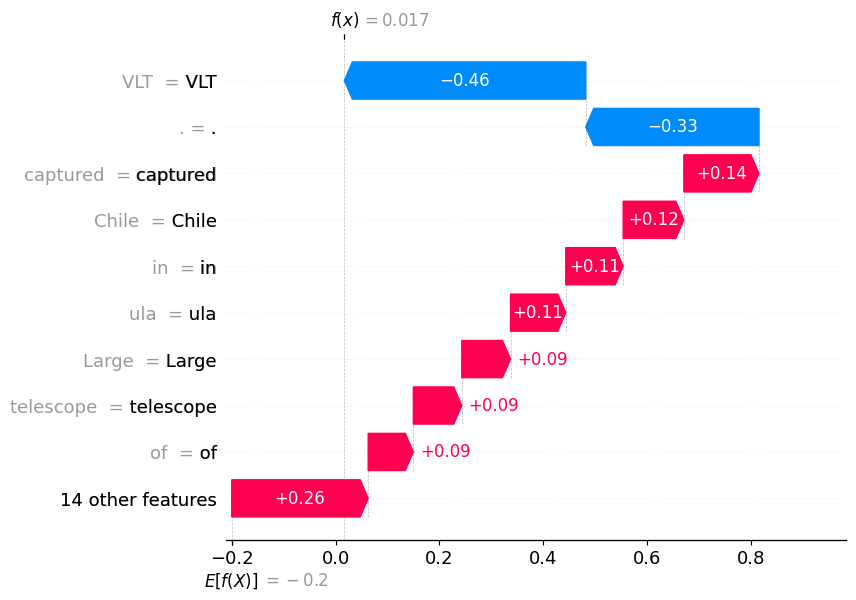

In [ ]:
shap.plots.waterfall(shap_values[0])

# Interpreting AstroBERT NER with Transformers Interpret

## Installation

In [ ]:
!pip install transformers
# !pip install transformers_interpret
!pip install git+https://github.com/golnazads/transformers-interpret.git@v0.10.0_beta

  Cloning https://github.com/golnazads/transformers-interpret.git (to revision v0.10.0_beta) to /tmp/pip-req-build-u05au88i
  Running command git clone --filter=blob:none --quiet https://github.com/golnazads/transformers-interpret.git /tmp/pip-req-build-u05au88i
  Resolved https://github.com/golnazads/transformers-interpret.git to commit f653dd027487bd78aa4ae237b41f9152328ae257
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import AstroBERT NER model

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# load astroBERT for NER-DEAL
remote_model_path = 'adsabs/astroBERT'
revision = 'NER-DEAL'

model = AutoModelForTokenClassification.from_pretrained(pretrained_model_name_or_path=remote_model_path, revision=revision)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=remote_model_path, add_special_tokens=True, do_lower_case=False)

Display all possible entity tags that this model classifies each token into:

In [ ]:
model.config.id2label

{0: 'B-Archive',
 1: 'B-CelestialObject',
 2: 'B-CelestialObjectRegion',
 3: 'B-CelestialRegion',
 4: 'B-Citation',
 5: 'B-Collaboration',
 6: 'B-ComputingFacility',
 7: 'B-Database',
 8: 'B-Dataset',
 9: 'B-EntityOfFutureInterest',
 10: 'B-Event',
 11: 'B-Fellowship',
 12: 'B-Formula',
 13: 'B-Grant',
 14: 'B-Identifier',
 15: 'B-Instrument',
 16: 'B-Location',
 17: 'B-Mission',
 18: 'B-Model',
 19: 'B-ObservationalTechniques',
 20: 'B-Observatory',
 21: 'B-Organization',
 22: 'B-Person',
 23: 'B-Proposal',
 24: 'B-Software',
 25: 'B-Survey',
 26: 'B-Tag',
 27: 'B-Telescope',
 28: 'B-TextGarbage',
 29: 'B-URL',
 30: 'B-Wavelength',
 31: 'I-Archive',
 32: 'I-CelestialObject',
 33: 'I-CelestialObjectRegion',
 34: 'I-CelestialRegion',
 35: 'I-Citation',
 36: 'I-Collaboration',
 37: 'I-ComputingFacility',
 38: 'I-Database',
 39: 'I-Dataset',
 40: 'I-EntityOfFutureInterest',
 41: 'I-Event',
 42: 'I-Fellowship',
 43: 'I-Formula',
 44: 'I-Grant',
 45: 'I-Identifier',
 46: 'I-Instrument',
 47

## Create a pipeline and see a tagged example

In [ ]:
from transformers import TokenClassificationPipeline

pipeline = TokenClassificationPipeline(model=model, tokenizer=tokenizer, task='astroBERT NER_DEAL', aggregation_strategy='average', ignore_labels=['O'])

In [ ]:
example = "The VLT telescope in Chile captured an image of the Tarantula Nebula in the Large Magellanic Cloud galaxy."
results = pipeline(example)
for result in results:
  print(result)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'entity_group': 'Telescope', 'score': 0.556757, 'word': 'The', 'start': 0, 'end': 3}
{'entity_group': 'Telescope', 'score': 0.84752667, 'word': 'VLT telescope', 'start': 4, 'end': 17}
{'entity_group': 'Location', 'score': 0.5440941, 'word': 'Chile', 'start': 21, 'end': 26}
{'entity_group': 'CelestialObject', 'score': 0.69072115, 'word': 'Tarantula Nebula', 'start': 52, 'end': 68}
{'entity_group': 'CelestialObject', 'score': 0.73234534, 'word': 'Large Magellanic Cloud', 'start': 76, 'end': 98}



## Import from the *transformers interpret* package, and create the explainer

In [ ]:
from transformers_interpret import TokenClassificationExplainer

explainer = TokenClassificationExplainer(model=model, tokenizer=tokenizer)

## Run the example with the explainer

In [ ]:
attributions = explainer(example, ignored_labels=['O'])
attributions

{'The': {'label': 'I-Telescope',
  'attribution_scores': [('[CLS]', 0.0),
   ('The', 0.39404618540943986),
   ('VLT', 0.4032809871300941),
   ('telescope', 0.4329206693596886),
   ('in', 0.01018469870164287),
   ('Chile', 0.15245197646448883),
   ('captured', -0.2877084558627176),
   ('an', 0.08757340148654837),
   ('image', 0.24272602368535665),
   ('of', 0.050529239886914636),
   ('the', -0.0902487210943725),
   ('Tar', -0.04819554797369146),
   ('##ant', 0.05414390775423047),
   ('##ula', 0.0645690459306804),
   ('Nebula', 0.08048425631796283),
   ('in', 0.03090513289673615),
   ('the', 0.029915728929490362),
   ('Large', 0.09720567592865653),
   ('Magellanic', 0.14744365647140595),
   ('Cloud', 0.05383900649762496),
   ('galaxy', 0.07702360612173634),
   ('.', -0.5034838793913254),
   ('[SEP]', 0.0)]},
 'VLT': {'label': 'B-Telescope',
  'attribution_scores': [('[CLS]', 0.0),
   ('The', 0.9249230809851489),
   ('VLT', 0.009249756523078573),
   ('telescope', 0.04146837596077972),
   

Visualizing explanations

In [ ]:
html = explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
I-Telescope,I-Telescope (0.56),The,1.48,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
B-Telescope,B-Telescope (0.74),VLT,1.79,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
I-Telescope,I-Telescope (0.96),telescope,1.38,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
B-Location,B-Location (0.54),Chile,1.63,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
B-CelestialObject,B-CelestialObject (0.62),Tar,2.93,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
I-CelestialObject,I-CelestialObject (0.59),##ant,0.85,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
I-CelestialObject,I-CelestialObject (0.78),##ula,1.22,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
I-CelestialObject,I-CelestialObject (0.88),Nebula,1.61,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
B-CelestialObject,B-CelestialObject (0.61),Large,2.67,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
I-CelestialObject,I-CelestialObject (0.72),Magellanic,1.11,[CLS] The VLT telescope in Chile captured an image of the Tar ##ant ##ula Nebula in the Large Magellanic Cloud galaxy . [SEP]
